In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
import pyproj

## CO JESZCZE:
* ULEPSZYC PLIK SHP, (ten zapisany w geo jednostkach wrzucic na gita i z niego korzystac, drugi tylko na zapas)NAZWY DZIELNIC ZACZYNAJACE SIE WIELKĄ, POLSKIE LITERY, KODOWANIE, reszte kolumn wyrzucić z pliku shp
* DOPRACOWAĆ JEDNORAZOWE WYKONYWANIE
* WSZYSTKIE DANE W RAMCE POPRAWNIE ZJOINOWANE
* SKALA - SPOJRZEĆ JAKIE SA NORMY UNIJNE, WEDŁUG NICH ZROBIĆ SKALĘ Z ŁADNYMI KOLORAMI, TAK PO DWA ODCIENIE NA KAŻDY STOPIEŃ SKALI? CO TO AIR QUALITY INDEX (ŁATWE)
* DRUKOWAĆ TEŻ WYNIK DLA NAJGORSZYCH DZIELNIC I NAPISAĆ NA DOLE JAKA JEST NORMA (ŁATWE) 
* WYKRESY Z DZIENNĄ TEMPERATURĄ I CIŚNIENIEM ATMOSFERYCZNYM DLA RYBNIKA W CIĄGU DOBY?
* JAK ZAZNACZAĆ PUNKTY NA MAPIE?
  * JAK PISAĆ TEKST NA MAPIE?
  * MAPA Z MAKSYMALNĄ PRZEWIDYWANĄ TEMPERATURĄ I AKTUALNĄ W NAWIASIE? I CIŚNIENIEM?
  
  * CZY BĘDZIE CZYTELNIE WKLEJAJĄC NA MAPĘ LICZBY? MOŻE TYLKO SKRAJNE, TEMPERATURY DLA ŚRÓDMIEŚCIA PODAWAĆ JAKO DLA CAŁOŚCI?




# data/city.shp - wspolrzedne inne
# city_geo.shp - wspolrzedne geograficzne

# https://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.WsX2taOsZPZ

In [5]:
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

In [6]:
import requests

headers = {
    'Accept': 'application/json',
    'apikey': '***',
}

#rybnik's geographical coordinates
params = (
    ('southwestLat', '50.033'),
    ('southwestLong', '18.428'),
    ('northeastLat', '50.180'),
    ('northeastLong', '18.662'),
)

response = requests.get('https://airapi.airly.eu/v1/sensors/current', headers=headers, params=params)

In [7]:
data_js = response.json()

In [8]:
#only official rybnik's sensors
df_temp = pd.DataFrame.from_records(data_js).query("name == 'Rybnik' and vendor == 'Airly'")

#unfold address dict
df_temp = pd.concat([df_temp.drop(['address'], axis=1), df_temp['address'].apply(pd.Series)], axis=1)
#unfold location dict
sensors = pd.concat([df_temp.drop(['location'], axis=1), df_temp['location'].apply(pd.Series)], axis=1).reset_index(drop=True)

In [357]:
sensors

,name,pollutionLevel,vendor,country,locality,route,streetNumber,latitude,longitude,level
id,,,,,,,,,,
2083,Rybnik,1,Airly,Poland,"Rybnik, Chwałęcice",Gzelska 7,ZSP 15,50.133136,18.485427,1
2091,Rybnik,1,Airly,Poland,"Rybnik, Maroko-Nowiny",Orzepowicka 15a,ZS 3,50.100009,18.517341,1
2094,Rybnik,1,Airly,Poland,"Rybnik, Smolna",W. Reymonta 69,SP 34,50.090576,18.526136,1
2107,Rybnik,1,Airly,Poland,"Rybnik, Śródmieście",T. Kościuszki 5,ZST,50.096996,18.549377,1
2174,Rybnik,1,Airly,Poland,"Rybnik, Golejów",Komisji Edukacji Narodowej 29,ZSP 4,50.143863,18.540533,1
2198,Rybnik,1,Airly,Poland,"Rybnik, Ochojec",B. Kuglera 8a,ZSP 3,50.164684,18.546913,1
2202,Rybnik,1,Airly,Poland,"Rybnik, Paruszowiec-Piaski",Wolna 17,SP 3,50.096382,18.583908,1
2206,Rybnik,1,Airly,Poland,"Rybnik, Niewiadom",Sportowa 52,SP 23,50.074623,18.465013,1
2211,Rybnik,1,Airly,Poland,"Rybnik, Boguszowice Osiedle",J. Lompy 6,ZSP 8,50.048667,18.605903,4


# ---------------------------------------

# Wczytywanie shp i robienie z tego mapy bazowej

### Według skryptu londyńskiego

In [426]:
shp = fiona.open('data/city.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [427]:
w, h

(0.21515535742062042, 0.15026264550883894)

In [425]:
m = Basemap(
    projection='tmerc',
    lon_0=18,
    lat_0=50.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - 2*extra * w,
    llcrnrlat=coords[1] - 2*extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/city',
    'rybnik',
    color='none',
    zorder=2)

(27,
 5,
 [18.44168423057649, 50.03540818733495, 0.0, 0.0],
 [18.656839587997112, 50.18567083284379, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x199d48d0>)

In [428]:
m.rybnik_info[0]

{'RINGNUM': 1, 'SHAPENUM': 1, 'id': 2269, 'name': 'Stodo\xc5\x82y'}

In [309]:
sensors['level'] = pd.Series([1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 1, 1, 1, 1, 1])
sensors.iloc[:,-1] = [1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 1, 1, 1, 1, 1]

In [310]:
sensors.head()

,name,pollutionLevel,vendor,country,locality,route,streetNumber,latitude,longitude,level
id,,,,,,,,,,
2083,Rybnik,1,Airly,Poland,"Rybnik, Chwałęcice",Gzelska 7,ZSP 15,50.133136,18.485427,1
2091,Rybnik,1,Airly,Poland,"Rybnik, Maroko-Nowiny",Orzepowicka 15a,ZS 3,50.100009,18.517341,1
2094,Rybnik,1,Airly,Poland,"Rybnik, Smolna",W. Reymonta 69,SP 34,50.090576,18.526136,1
2107,Rybnik,1,Airly,Poland,"Rybnik, Śródmieście",T. Kościuszki 5,ZST,50.096996,18.549377,1
2174,Rybnik,1,Airly,Poland,"Rybnik, Golejów",Komisji Edukacji Narodowej 29,ZSP 4,50.143863,18.540533,1


In [429]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.rybnik],
    'ward_name': [ward['name'] for ward in m.rybnik_info]})
#df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
#df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(sensors['longitude'], sensors['latitude'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

In [312]:
poll_level = pd.Series(x for x in sensors['level'])

In [430]:
df_map.head()

,poly,ward_name
0,"POLYGON ((825.8616743265666 15417.40655400621,...",Stodoły
1,"POLYGON ((2970.626821254806 8531.536340018794,...",Zebrzydowice
2,"POLYGON ((5102.891005537214 16534.4525668647, ...",Ochojec
3,"POLYGON ((9403.58215873237 12910.25350248723, ...",Kamień
4,"POLYGON ((10315.74121566368 4191.036626162298,...",Boguszowice Osiedle


In [314]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [431]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))
df_map['level'] = poll_level
#df_map['density_m'] = df_map['count'] / df_map['area_m']
#df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
#df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

In [432]:
df_map.head()

,poly,ward_name,count,level
0,"POLYGON ((825.8616743265666 15417.40655400621,...",Stodoły,1,1
1,"POLYGON ((2970.626821254806 8531.536340018794,...",Zebrzydowice,1,1
2,"POLYGON ((5102.891005537214 16534.4525668647, ...",Ochojec,1,1
3,"POLYGON ((9403.58215873237 12910.25350248723, ...",Kamień,1,1
4,"POLYGON ((10315.74121566368 4191.036626162298,...",Boguszowice Osiedle,1,1


In [318]:
df_map['poly'].map(lambda x: (filter(prep(x).contains, ldn_points)))

0     [POINT (2762.830203556954 15279.83321320833)]
1      [POINT (3890.971488001498 9472.99188695082)]
2     [POINT (7729.812284031326 16488.46837254209)]
3     [POINT (11788.32946308081 13742.47898559144)]
4     [POINT (12049.34805902945 3616.455957538437)]
5     [POINT (12744.16659438186 6567.014031947258)]
6     [POINT (13505.49460139069 4313.788396152432)]
7      [POINT (11562.9536543859 4997.648164662324)]
8     [POINT (4521.181127825559 5970.502587187993)]
9      [POINT (5360.548878554353 4143.93871951254)]
10    [POINT (1940.444841521097 6431.236417140794)]
11     [POINT (6253.760044672166 4227.78134488065)]
12    [POINT (7901.249620967832 5868.651451950371)]
13    [POINT (10076.93024983295 8177.303659342162)]
14    [POINT (10432.52839372739 8911.229729700948)]
15    [POINT (7290.736850450408 14169.20255858056)]
16    [POINT (3359.460579162722 12948.95375495657)]
17    [POINT (6066.398295323608 13805.29798521491)]
18     [POINT (6244.29776963282 12034.10903712503)]
19    [POINT

In [319]:
# # Calculate Jenks natural breaks for density
# breaks = nb(
#     df_map[df_map['level'].notnull()].level.values,
#     initial=0,
#     k=4)
# # the notnull method lets us match indices when joining
# jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
# df_map = df_map.join(jb)
# df_map.jenks_bins.fillna(-1, inplace=True)

In [445]:
jenks_labels = ['0 - 50 (Dobra)',
 '51 - 100 (Średnia)',
 '101 - 150 (Niezdrowa dla osob wrażliwych)',
 '151 - 200 (Niezdrowa)']

for i, text in enumerate(jenks_labels):
    jenks_labels[i] = text.decode('utf-8')

In [446]:
jenks_labels

[u'0 - 50 (Dobra)',
 u'51 - 100 (\u015arednia)',
 u'101 - 150 (Niezdrowa dla osob wra\u017cliwych)',
 u'151 - 200 (Niezdrowa)']

In [400]:
df_map.head()

,poly,ward_name,count,level,patches
0,"POLYGON ((825.8616743265666 15417.40655400621,...",STODOLY,1,1,"Poly((825.862, 15417.4) ...)"
1,"POLYGON ((2970.626821254806 8531.536340018794,...",ZEBRZYDOWICE,1,1,"Poly((2970.63, 8531.54) ...)"
2,"POLYGON ((5102.891005537214 16534.4525668647, ...",OCHOJEC,1,1,"Poly((5102.89, 16534.5) ...)"
3,"POLYGON ((9403.58215873237 12910.25350248723, ...",KAMIEN,1,1,"Poly((9403.58, 12910.3) ...)"
4,"POLYGON ((10315.74121566368 4191.036626162298,...",BOGUSZOWICE OSIEDLE,1,1,"Poly((10315.7, 4191.04) ...)"


In [402]:
from matplotlib import colors
cmap = colors.ListedColormap(['#4ca74a','#ffd800','#fb7551','#fb5656'])#,'#8e3ac4', '#b10000'])
bounds= [1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

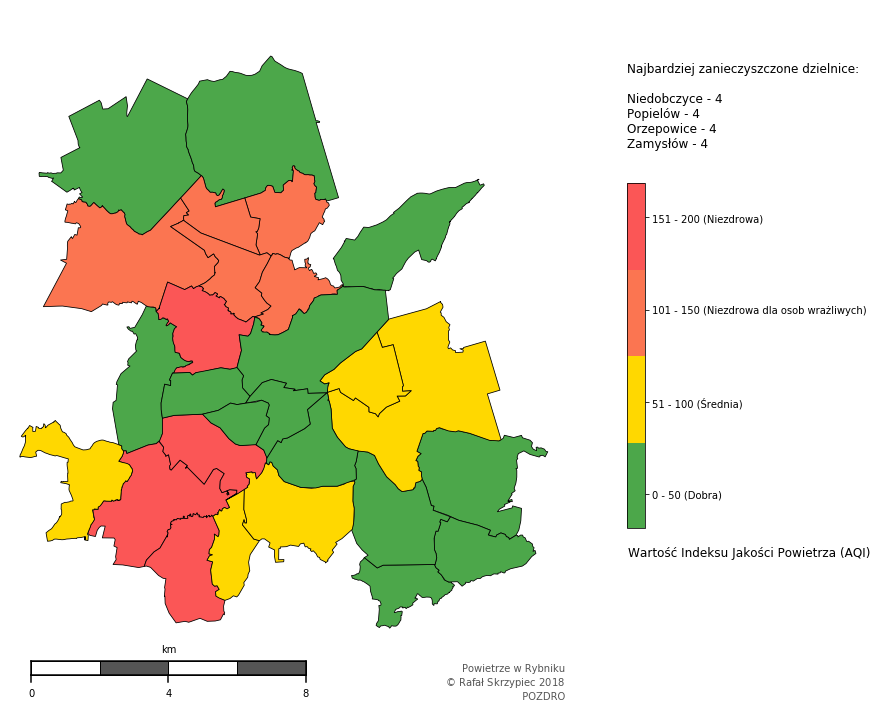

In [456]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
#cmap = plt.get_cmap('RdYlGn_r')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['level'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(value[3]) for _, value in df_map[(df_map['level'] == 4)][:5].sort_index().iterrows()).decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.35,
    highest,
    ha='left', va='top',
    size=12,
    color='#000000')

# Bin method, copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Powietrze w Rybniku\n$\copyright$ Rafał Skrzypiec 2018\n  POZDRO'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    color='#555555',
    transform=ax.transAxes)

# Mapscale label
label = 'Wartość Indeksu Jakości Powietrza (AQI)'
mapscale_label = cb.ax.text(
    0.05, -0.05,
    label.decode('utf-8'),
    ha='left', va='top',
    size=12,
    color='#000000')

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#000000', fontsize=10,
    zorder=5)
# this will set the image width to 1000px at 100dpi
plt.tight_layout()
fig.set_size_inches(12, 10)
plt.savefig('ryyyb1.png', dpi=200, alpha=True)
plt.show()